# RapidWright Tutorial - Creating an EDIF Netlist from Scratch
In this Jupyter notebook tutorial, we illustrate how to: 
 1. Use the low level EDIF APIs found in RapidWright
 2. Create a simple, hierarchical circuit inside RapidWright
 

## Background
Sometimes we may have to make small changes to a netlist or add specific circuit elements in a certain way to achieve the desired netlist.  RapidWright has a set of APIs that can manipulate the EDIF netlist in order to address these needs.  One useful reference to aid the user would be to read the [RapidWright documentation on the EDIF package](http://www.rapidwright.io/docs/RapidWright_Overview.html#edif-package-logical-netlist). 

This tutorial walks through the steps of creating the simple circuit below as a synthesized DCP:
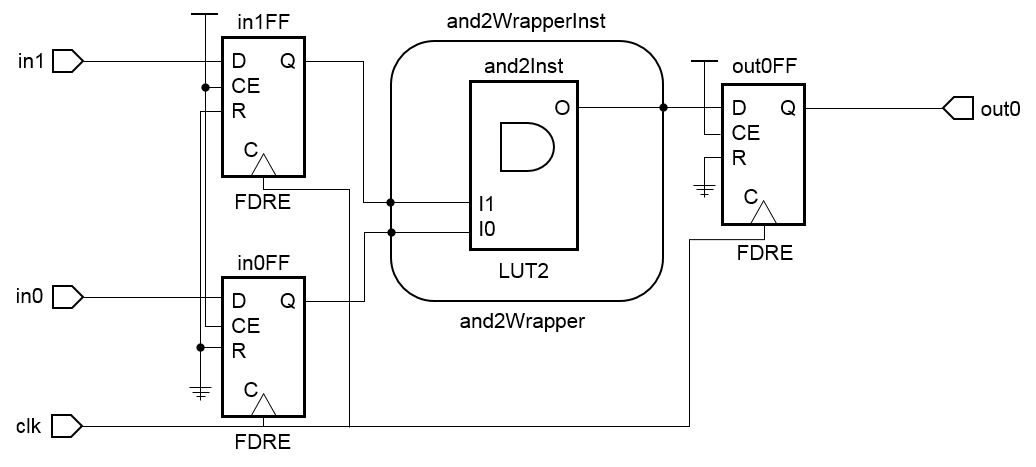

The process of creating the circuit is partitioned into four steps:
1. [Initializing the design and creating flops for each top-level port (except clk)](#step1)
2. [Creating top level ports and nets and connecting them ](#step2)
3. [Connecting clk, GND and VCC to appropriate flip flop instances](#step3)
4. [Creating the AND2/LUT2, hierarchy and connections](#step4)

<a id='step1'></a>
### Step 1: Initialize Design & Create Flip Flops
To create a new design, we Use the constructor on the `Design` class and pass it a part name (in this case, we just used a built-in reference for the PYNQ_Z1 board).  Even though we won't be doing anything with placement or routing, we still need the `Design` object.  The netlist is stored in an `EDIFNetlist` instance and is accessed by `Design.getNetlist()` as shown in line 21.  We are going to do some repetitive tasks based on the top-level pins in the design, so they are defined in a list for ease of iterating later.

In a netlist, each instance or `EDIFCellInst` must have a prototype or `EDIFCell` that describes its implementation.  This `EDIFCell` must also be included in the appropriate `EDIFLibrary` or Vivado will complain when the DCP is loaded that it can't find it and will treat it like a black box.  For this purpose, once we have an `FDRE` cell, we must also added it to the primitive library as shown in line 33 below.

To add an `EDIFCellInst` to a design, it must have a parent `EDIFCell`, in this case we are adding three flip flops to the top cell of the design in loop body (lines 36-38).  Finally, we write out a DCP to check our progress.

In [ ]:
# All imports used for example
import os, rapidwright
from com.xilinx.rapidwright.design import Design
from com.xilinx.rapidwright.design import NetType
from com.xilinx.rapidwright.design import Unisim
from com.xilinx.rapidwright.device import Device
from com.xilinx.rapidwright.edif import EDIFCell
from com.xilinx.rapidwright.edif import EDIFCellInst
from com.xilinx.rapidwright.edif import EDIFDirection
from com.xilinx.rapidwright.edif import EDIFNet
from com.xilinx.rapidwright.edif import EDIFNetlist
from com.xilinx.rapidwright.edif import EDIFPort
from com.xilinx.rapidwright.edif import EDIFTools
from com.xilinx.rapidwright.util import FileTools

# Initialize an empty design
design = Design("And2Example",Device.PYNQ_Z1)

# We set this to make the DCP Out-of-context -- otherwise Vivado 
#  will auto insert buffers on all the inputs
design.setAutoIOBuffers(False) 

# extracting some references for convenience
netlist = design.getNetlist()
top = netlist.getTopCell()

# Create some convenience variables
inDir = EDIFDirection.INPUT
outDir = EDIFDirection.OUTPUT
clk = "clk"
pinNames = [clk,   "in0", "in1", "out0"]
pinDirs  = [inDir, inDir, inDir, outDir]

# Make sure FDRE is added to the primitive library
ff = Design.getUnisimCell(Unisim.FDRE)
ff = netlist.getHDIPrimitivesLibrary().addCell(ff)

# Let's create a FF for each top level pin (except clk)
for pin in pinNames:
    if pin == clk: continue
    ffInst = top.createChildCellInst(pin + "FF", ff)

# Write out current progress
outputFileName = "and2example_1_just_flops.dcp"
design.writeCheckpoint(outputFileName)
print("Wrote DCP '" + os.path.join(os.getcwd(), outputFileName) + "' successfully")

**NOTE: Keep your Vivado instance open so you can open the other DCPs we will create later.**

If you are running your Jupyter Notebook server locally, you can run the cell below that will run Vivado and open the first DCP created above:

In [ ]:
# open up an instance of Vivado and load our freshly created DCP...
if FileTools.isWindows():
    os.system("START /B vivado " + outputFileName)
else:
    os.system("vivado "+outputFileName+" &")
print("If vivado fails to open or load, you could run the following command:")
print("")
print("    'vivado " + os.path.join(os.getcwd(), outputFileName) + "'")

If you are running your Jupyter Notebook remotely, you will need to download the created file by navigating back to the Jupyter Dashboard (click on the Jupyter icon at the top left of this page) and then open Vivado directly from the command line.  

Below provides a snapshot of the netlist we should have thus far:

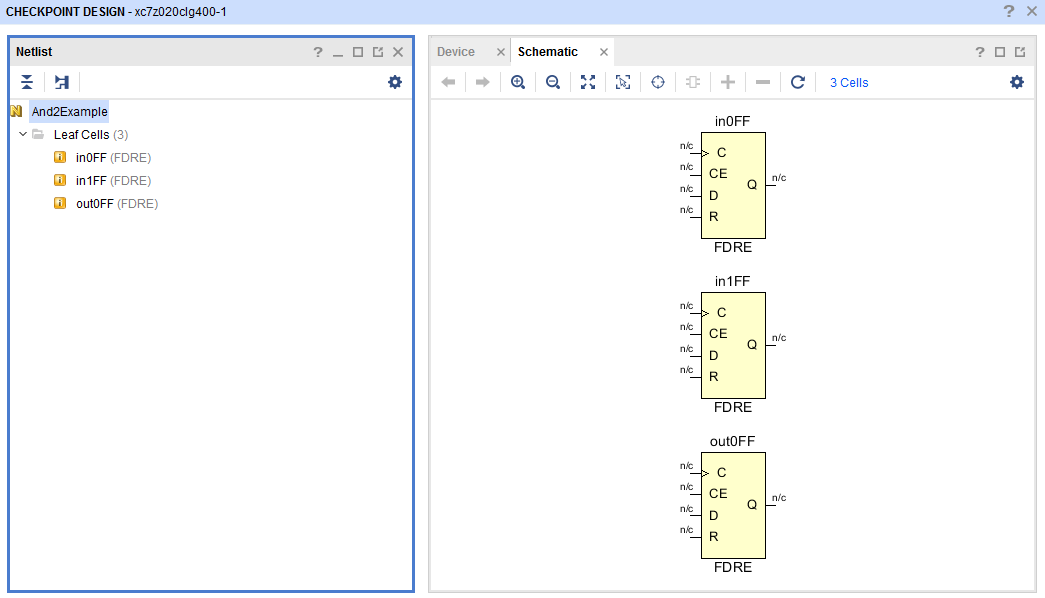
You can see that we have created a design that had three FDRE flip flops, but they aren't connected to anything yet.

<a id='step2'></a>
### Step 2: Create Top-level Ports and Nets
In the cell below, we are looping over both a list of top-level pin names and their directions simulataneously using the handy `zip` method.   For each top-level pin, we need to create a new net, a top-level port and connections between the top-level port and the associated flip flop. To make a connection on an `EDIFNet`, an `EDIFPortInst` is used.  Therefore, lines 8 and 15 below show how each net is connected to the top-level port and flip flop, respectively.  We don't need to connect the clk signal as it is a special case (line 11).

Again we write out our progress as a DCP and view the results in Vivado as shown in the image below the cell.

In [ ]:
# Create top level ports and connect them to flip flops
for name, direction in zip(pinNames,pinDirs):
    # creates a new net in the EDIFCell 'top'
    net = top.createNet(name)
    # creates a new port on the EDIFCell 'top'
    port = top.createPort(name,direction, 1)
    # connects the top-level port to the net
    net.createPortInst(port)
    
    # skip the top-level clk input for the last step
    if name == clk: continue    
    
    # connects the net to the flip flop
    ffInst = top.getCellInst(name+"FF")
    net.createPortInst("D" if direction == inDir else "Q", ffInst)
    
# Write out current progress
outputFileName = "and2example_2_flops_and_ports.dcp"
design.writeCheckpoint(outputFileName)
print("Wrote DCP '" + os.path.join(os.getcwd(), outputFileName) + "' successfully")

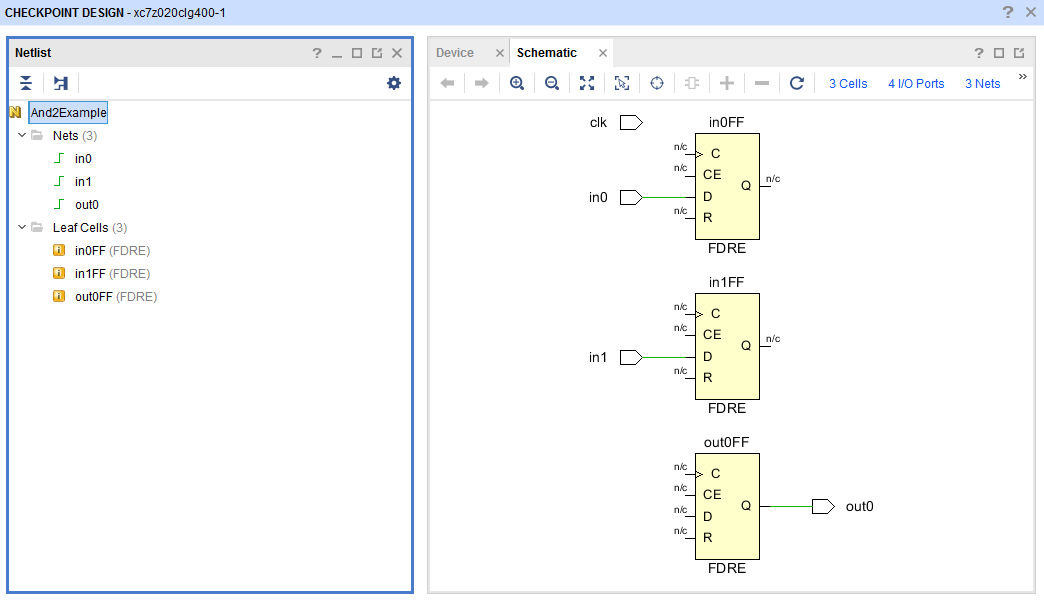
Now top-level ports are visible with nets being connected to the flip flops.

<a id='step3'></a>
### Step 3: Connect clk, GND and VCC to Flip Flops
Generally, any cell in a netlist that needs VCC or GND will supply it from a GND or VCC cell. RapidWright provides a convenience method in `EDIFTools` that automatically instantiates a VCC/GND cell, creates or gets the appropriate net, connects it to the cell and then returns it as shown in lines 2-3.  We need VCC and GND for the clock enable and reset lines on the flip flops.

As before, we create `EDIFPortInst` objects to create connectivity on an `EDIFNet` as shown in the loop body in lines 9-11.

We check our progress again by writing out a DCP at this point.

In [ ]:
# Gets or creates appropriate GND/VCC sources and nets in an EDIFCell
gnd = EDIFTools.getStaticNet(NetType.GND, top, netlist)
vcc = EDIFTools.getStaticNet(NetType.VCC, top, netlist)

# Connect clk, VCC/GND to CE/RST on flip flops
for name in pinNames:
    if name == clk: continue        
    ffInst = top.getCellInst(name+"FF")
    top.getNet(clk).createPortInst("C", ffInst);
    gnd.createPortInst("R", ffInst);
    vcc.createPortInst("CE", ffInst);
    
# Write out current progress
outputFileName = "and2example_3_flops_and_ports.dcp"
design.writeCheckpoint(outputFileName)
print("Wrote DCP '" + os.path.join(os.getcwd(), outputFileName) + "' successfully")

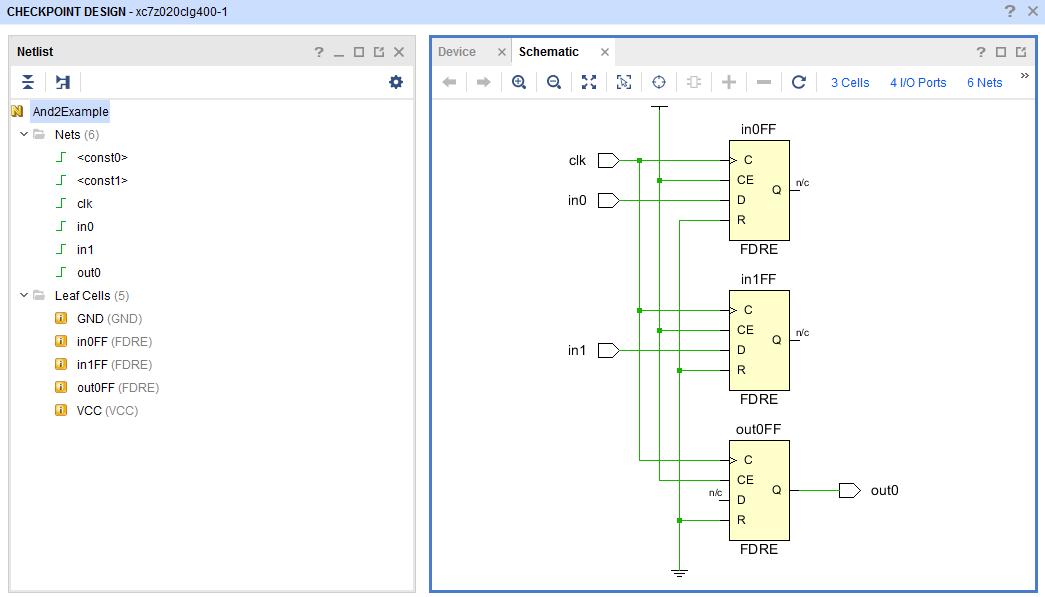
The flip flops are now fully connected except for their connections to the AND2 gate inside the wrapper that we still need to instantiate.

<a id='step4'></a>
### Step 4: Create Level of Hierarchy and AND2 Instance
We must create both an `EDIFCell` and an `EDIFCellInst` to create a level of hierarchy in the netlist.  As mentioned previously, the `EDIFCell` must belong to a library in the netlist.  In this case (line 2) we add it to the 'work' library which is the default for all non-primitive cells.  

Creation of the AND2 unisim cell automatically gets mapped to a LUT2 by the RapidWright APIs to follow Vivado convention.  

When making connections through a level of hierarchy as done here in `and2WrapperInst`, an `EDIFPortInst` must be created both on the outside facing (line 21) port and on the inside facing port (line 25).  Also, the inside facing port is connected to a net inside the `EDIFCell`.

The final implementation is written out as a DCP and the schematic matches our original circuit first presented above.

In [ ]:
# Create hierarchical cell and instance for AND2
and2Wrapper = EDIFCell(netlist.getWorkLibrary(), "and2Wrapper")
and2WrapperInst = top.createChildCellInst("and2WrapperInst", and2Wrapper)

# Create LUT2 AND gate and instance
and2 = Design.getUnisimCell(Unisim.AND2)
netlist.getHDIPrimitivesLibrary().addCell(and2)
and2Inst = and2Wrapper.createChildCellInst("and2Inst", and2)

# Make final connections between flip flops and wrapper/LUT
for name, direction in zip(pinNames,pinDirs):
    if name == clk: continue
    ffInst = top.getCellInst(name+"FF")    
    
    # creates a port for our custom and2Wrapper cell to pass in each flip flop signal
    port = and2Wrapper.createPort(name,direction, 1)
    
    # create a net and connect each flip flop to and2Wrapper
    net = top.createNet(name+"_2")
    net.createPortInst("Q" if direction == inDir else "D", ffInst)
    net.createPortInst(port, and2WrapperInst)
    
    # create a net inside the and2Wrapper and connect it to the AND2/LUT2
    innerNet = and2Wrapper.createNet(name)
    innerNet.createPortInst(port)
    innerNet.createPortInst("O" if name == "out0" else name.replace("in","I"), and2Inst)

# Write out current progress
outputFileName = "and2example_4_flops_and_lut.dcp"
design.writeCheckpoint(outputFileName)
print ("Wrote DCP '" + os.path.join(os.getcwd(), outputFileName) + "' successfully")

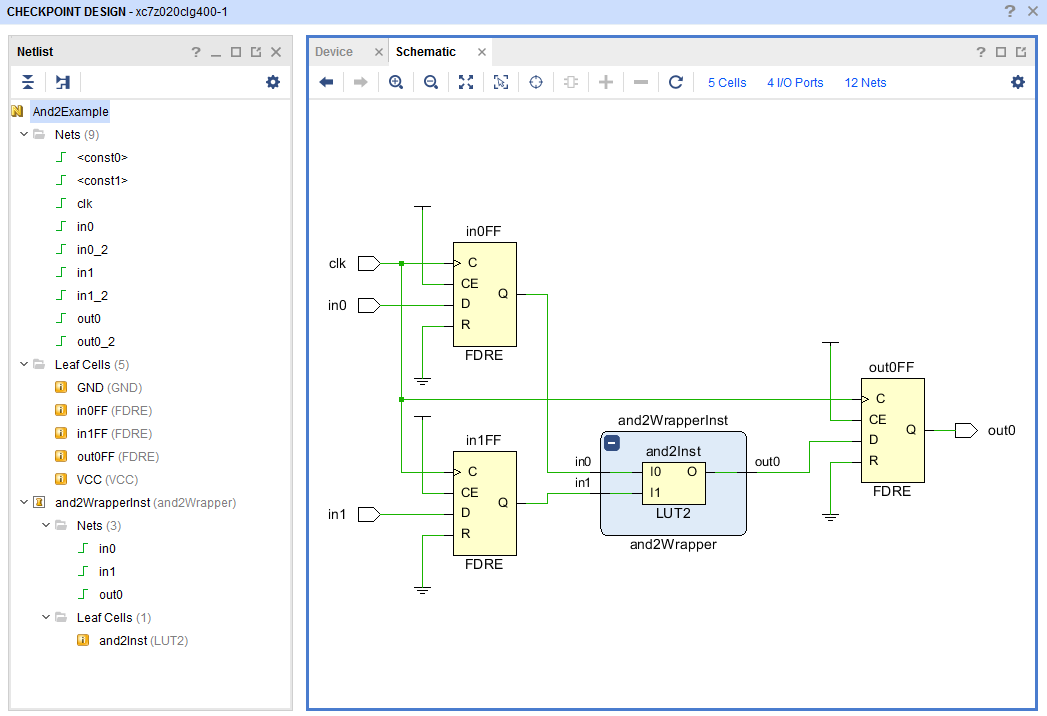
The final circuit completed

## Conclusion
This tutorial illustrates the basic netlist manipulation APIs in RapidWright.  Although this technique is not recommended for heavy circuit development, it allows fine-grained manipulation on small and existing circuits.